Imports

In [1]:
import os, json
import sys
root_dir = os.path.abspath(os.path.join(os.getcwd(), "..")) 
sys.path.append(root_dir)

hydragnn_path = os.path.abspath(os.path.join(os.getcwd(), "../src/models/")) 
sys.path.append(hydragnn_path)

import torch
import random
import numpy as np
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
import torch_geometric

# deprecated in torch_geometric 2.0
try:
    from torch_geometric.loader import DataLoader
except:
    from torch_geometric.data import DataLoader


from src.data.download_customqm9 import CustomQM9
import hydragnn

# Set this path for output.
try:
    os.environ["SERIALIZED_DATA_PATH"]
except:
    os.environ["SERIALIZED_DATA_PATH"] = os.getcwd()

device = torch.device("cuda")

Pre transforms

In [2]:
# Update each sample prior to loading.
def qm9_pre_transform(data):
    # Set descriptor as element type.
    # data.x = data.z.float().view(-1, 1)
    # Only predict dipole moment for this run
    # print(data.y)
    data.y = data.y[:, 0] #/ len(data.x)
    # print(data.y)
    graph_features_dim = [1]
    node_feature_dim = [1]
    return data


Load config file

In [3]:
# Configurable run choices (JSON file that accompanies this example script).
if default:=False:   
    filename = "./model_configs/gnn/qm9.json"
else:
    filename = "./model_configs/gnn/best.json"
with open(filename, "r") as f:
    config = json.load(f)
verbosity = config["Verbosity"]["level"]


Load Dataset

In [4]:


# Always initialize for multi-rank training.
world_size, world_rank = hydragnn.utils.setup_ddp()

log_name = "qm9_test"
# Enable print to log file.
hydragnn.utils.setup_log(log_name)

# Use built-in torch_geometric dataset.
# Filter function above used to run quick example.
# NOTE: data is moved to the device in the pre-transform.
# NOTE: transforms/filters will NOT be re-run unless the qm9/processed/ directory is removed.
dataset = list(torch_geometric.datasets.QM9(
    root="../data/qm9", pre_transform=qm9_pre_transform, #pre_filter=qm9_pre_filter
))

# new_dataset = []
# for data in dataset:
    # new_dataset.append(data.to(device)) 
# 
# dataset = new_dataset



Distributed data parallel: nccl master at 127.0.0.1:8889


What does the data look like?

In [5]:
print(dataset[0].y)
print(dataset[1].y)
print(dataset[2].y)

print(len(dataset))


config["NeuralNetwork"]["Variables_of_interest"]["input_node_features"] = list(range(len(dataset[0].x[0])))

tensor([0.])
tensor([1.6256])
tensor([1.8511])
130831


Train the model

In [ ]:
train, val, test = hydragnn.preprocess.split_dataset(
    dataset, config["NeuralNetwork"]["Training"]["perc_train"], False, "../data/etc/split_idxs.pt"
)
(train_loader, val_loader, test_loader,) = hydragnn.preprocess.create_dataloaders(
    train, val, test, config["NeuralNetwork"]["Training"]["batch_size"], pin_memory=False
)

# print(config["NeuralNetwork"]["Architecture"]["hidden_dim"])


config = hydragnn.utils.update_config(config, train_loader, val_loader, test_loader)

def run(config, return_model=False): 
    model = hydragnn.models.create_model_config(
        config=config["NeuralNetwork"],
        verbosity=verbosity,
    )
    model = hydragnn.utils.get_distributed_model(model, verbosity)

    learning_rate = config["NeuralNetwork"]["Training"]["Optimizer"]["learning_rate"]
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler_config = config["NeuralNetwork"]["Training"]["ReduceLROnPlateau"]
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=scheduler_config["factor"], patience=scheduler_config["patience"], min_lr=scheduler_config["min_lr"]
    )

    # Run training with the given model and qm9 dataset.
    writer = hydragnn.utils.get_summary_writer(log_name)
    hydragnn.utils.save_config(config, log_name)

    hydragnn.train.train_validate_test(
        model,
        optimizer,
        train_loader,
        val_loader,
        test_loader,
        writer,
        scheduler,
        config["NeuralNetwork"],
        log_name,
        verbosity,
    )

    #Report here


    if return_model:
        return model

model = run(config, True)

Using existing QM9 index split. Delete the split and rerun this if you changed the settings.


0: Using GPU
0: Using GPU
Test: 100%|██████████| 154/154 [00:01<00:00, 123.14it/s]
0: Epoch: 00, Train Loss: 1.07992816, Val Loss: 0.97709823, Test Loss: 0.95091331
0: Tasks Loss: [1.0799281597137451]
Test: 100%|██████████| 154/154 [00:01<00:00, 118.15it/s]
0: Epoch: 01, Train Loss: 0.93539613, Val Loss: 0.92657107, Test Loss: 0.90181911
0: Tasks Loss: [0.935396134853363]
Test: 100%|██████████| 154/154 [00:01<00:00, 121.09it/s]
0: Epoch: 02, Train Loss: 0.88999134, Val Loss: 0.88334447, Test Loss: 0.85626471
0: Tasks Loss: [0.8899913430213928]
Test: 100%|██████████| 154/154 [00:01<00:00, 125.45it/s]
0: Epoch: 03, Train Loss: 0.84955937, Val Loss: 0.83066493, Test Loss: 0.80871260
0: Tasks Loss: [0.8495593667030334]
Test: 100%|██████████| 154/154 [00:01<00:00, 111.32it/s]
0: Epoch: 04, Train Loss: 0.80217016, Val Loss: 0.79842889, Test Loss: 0.77522570
0: Tasks Loss: [0.8021701574325562]
Test: 100%|██████████| 154/154 [00:01<00:00, 116.37it/s]
0: Epoch: 05, Train Loss: 0.75393760, Val L

In [11]:
torch.save(model.state_dict(), '../models/gnn/best_gnn.pth')

Visualization

Test Loss (MSE): 0.374305
Test RMSE: 0.611805
Test MAE: 0.439186



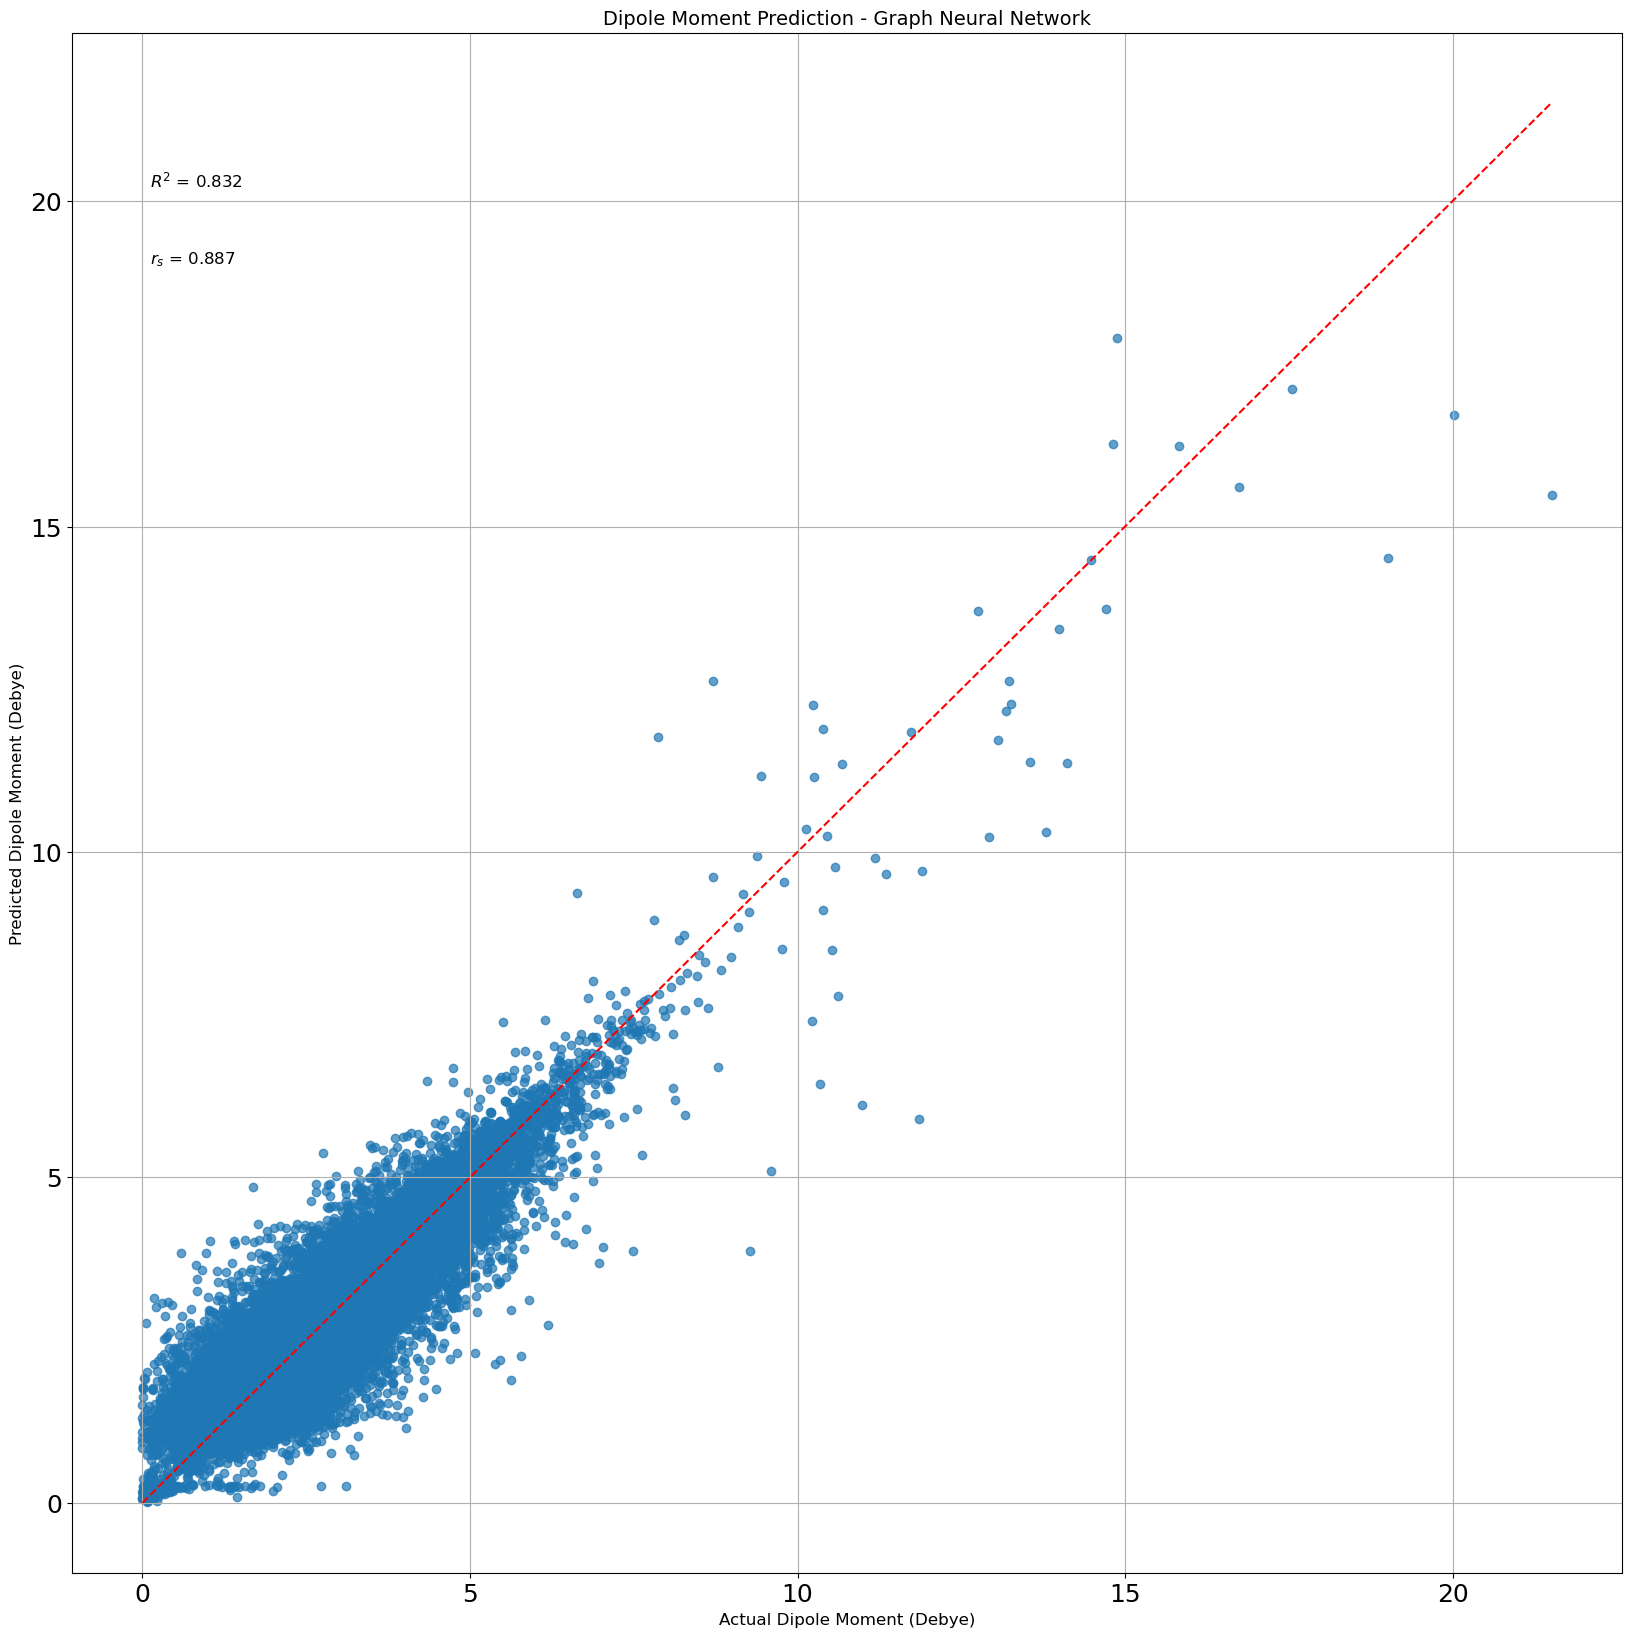

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from torch.nn.functional import mse_loss, l1_loss
from math import sqrt

model.eval() 
true_values = []
predicted_values = []

test_loss_mse = 0.0
test_loss_mae = 0.0
with torch.no_grad(): 
    for data in test_loader: 
        data = data.to(device)
        output = model(data)  

        # Assuming 'dipole_moment' is the only output head 
        predictions = output[0]
        
        data.y = data.y.unsqueeze(1)

        test_loss_mse += mse_loss(predictions, data.y).item() * config["NeuralNetwork"]["Training"]["batch_size"]
        test_loss_mae += l1_loss(predictions, data.y).item() * config["NeuralNetwork"]["Training"]["batch_size"]

        true_values.extend(data.y.cpu().detach())
        predicted_values.extend(predictions.cpu().detach())

    test_loss_mse /= len(test_loader.dataset)
    test_loss_mae /= len(test_loader.dataset)
        
print(f'Test Loss (MSE): {test_loss_mse:.6f}')
print(f'Test RMSE: {sqrt(test_loss_mse):.6f}')
print(f'Test MAE: {test_loss_mae:.6f}')

print()
# print(predicted_values[0])
# print(predicted_values[0].size())
# Create visualizations
# visualizer.create_plot_global_analysis(varname="dipole_moment", true_values=true_values, predicted_values=predicted_values)
# visualizer.create_scatter_plots(true_values, predicted_values, output_names="dipole_moment")

true_values = torch.cat(true_values, dim=0).unsqueeze(1)
predicted_values = torch.cat(predicted_values, dim=0).unsqueeze(1)

# print(true_values.size())

# visualizer.create_parity_plot_and_error_histogram_scalar(
#         varname
#         true_values, 
#         predicted_values, 
#         iepoch=2,
#         # output_names="dipole_moment", 
#     )
# visualizer.create_parity_plot_and_error_histogram_scalar(varname="dipole_moment", true_values=true_values, predicted_values=predicted_values, iepoch=2)


r2 = r2_score(true_values.cpu().numpy(), predicted_values.cpu().numpy())
src, _ = spearmanr(true_values.cpu().numpy(), predicted_values.cpu().numpy())

# Create the plot
plt.figure(figsize=(20, 20)) 
plt.scatter(true_values, predicted_values, alpha=0.7)  # Plot the data points

# Add labels and title
plt.xlabel("Actual Dipole Moment (Debye)", fontsize=12)
plt.ylabel("Predicted Dipole Moment (Debye)", fontsize=12)
plt.title("Dipole Moment Prediction - Graph Neural Network", fontsize=14)

# Add R-squared value to the plot
plt.text(0.05, 0.9, f"$R^2$ = {r2:.3f}", fontsize=12, transform=plt.gca().transAxes)

plt.text(0.05, 0.85, f"$r_s$ = {src:.3f}", fontsize=12, transform=plt.gca().transAxes)

# Add a diagonal line for reference (perfect prediction)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], linestyle='--', color='red')

plt.grid(True) 
%matplotlib inline
plt.savefig("gnn_fig.png")
plt.show()